* Day Count Convention	30/360
* O/N Leg Frequency	Daily
* Fixed Leg Frequency	Annual


In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# handy it seems
# https://docs.sympy.org/latest/modules/solvers/solvers.html
from sympy.solvers import solve
from sympy import Symbol


# read data
irs_data = pd.read_csv("../data/IRS_Data.csv")
irs_data.columns = map(str.lower, irs_data.columns)

# use dict comprehension?
tenor_mapping = {
    "6m": 0.5,
    "1y": 1,
    "2y": 2,
    "3y": 3,
    "4y": 4,
    "5y": 5,
    "7y": 7,
    "10y": 10,
    "15y": 15,
    "20y": 20,
    "30y": 30,
}

# OIS processing
irs_data["tenor"] = irs_data["tenor"].map(tenor_mapping)
irs_data["rate"] = irs_data["rate"].str.strip("%").astype(float) / 100.0
irs_data["tenor_diff"] = irs_data["tenor"] - irs_data["tenor"].shift()
irs_data["tenor_diff"].fillna(0, inplace=True)
irs_data["interp_count"] = (irs_data["tenor_diff"] / 0.5).astype(int)
# DAY COUNT CONVENTION IS 30/360
FULL_YEAR = 360

In [48]:
irs_data

,tenor,product,rate,tenor_diff,interp_count
0,0.5,LIBOR,0.0250,0.0,0
1,1.0,IRS,0.0280,0.5,1
2,2.0,IRS,0.0300,1.0,2
3,3.0,IRS,0.0315,1.0,2
4,4.0,IRS,0.0325,1.0,2
5,5.0,IRS,0.0330,1.0,2
6,7.0,IRS,0.0350,2.0,4
7,10.0,IRS,0.0370,3.0,6
8,15.0,IRS,0.0400,5.0,10
9,20.0,IRS,0.0450,5.0,10


##  solve for < 1 y stuff ##

Because these 2 are anchors i believe

In [49]:
irs_data.loc[0, "disc_factor"] = 1 / (
    1 + irs_data.loc[0, "tenor"] * irs_data.loc[0, "rate"]
)

In [50]:
irs_data.loc[1, "disc_factor"] = (
    1 - 0.5 * irs_data.loc[1, "rate"] * irs_data.loc[0, "disc_factor"]
) / (1 + 0.5 * irs_data.loc[1, "tenor"] * irs_data.loc[1, "rate"])

In [51]:
irs_data

,tenor,product,rate,tenor_diff,interp_count,disc_factor
0,0.5,LIBOR,0.0250,0.0,0,0.987654
1,1.0,IRS,0.0280,0.5,1,0.972557
2,2.0,IRS,0.0300,1.0,2,NaN
3,3.0,IRS,0.0315,1.0,2,NaN
4,4.0,IRS,0.0325,1.0,2,NaN
5,5.0,IRS,0.0330,1.0,2,NaN
6,7.0,IRS,0.0350,2.0,4,NaN
7,10.0,IRS,0.0370,3.0,6,NaN
8,15.0,IRS,0.0400,5.0,10,NaN
9,20.0,IRS,0.0450,5.0,10,NaN


## We may begin interpolation ##

In [52]:
previous_disc_factors = irs_data.loc[0:1, "disc_factor"].to_numpy()
print(previous_disc_factors)

[0.98765432 0.97255704]


In [53]:
for k in range(2, 11):
    interp_count = irs_data.loc[k, "interp_count"]
    mul_fact = 1.0 / interp_count
    rate = irs_data.loc[k, "rate"]
    max_sum = sum(range(1, int(irs_data.loc[k, "interp_count"])))
    regressor = mul_fact * max_sum

    print(
        f"{rate} need interp by {interp_count} , result is {mul_fact} * {max_sum} = {regressor}"
    )
    pv_fix_wo_unknown = (
        previous_disc_factors.sum() + regressor * previous_disc_factors[-1]
    )
    print(pv_fix_wo_unknown)
    pv_float_wo_unknown = 1
    x = Symbol("x")
    tosolve = solve(
        rate * 0.5 * (pv_fix_wo_unknown + regressor * x + x) - (pv_float_wo_unknown - x)
    )
    # print(tosolve[0])
    irs_data.loc[k, "disc_factor"] = tosolve[0]

    # find points between
    interpolated_disc_factors = []
    diff_factor = mul_fact * (
        irs_data.loc[k, "disc_factor"] - irs_data.loc[k - 1, "disc_factor"]
    )

    for x in range(1, int(irs_data.loc[k, "interp_count"])):
        to_append = irs_data.loc[k - 1, "disc_factor"] + diff_factor * x
        # print(f"{x} = {to_append}")
        interpolated_disc_factors.append(to_append)
    # append them
    previous_disc_factors = np.append(previous_disc_factors, interpolated_disc_factors)
    previous_disc_factors = np.append(
        previous_disc_factors, irs_data.loc[k, "disc_factor"]
    )
    print(previous_disc_factors)


0.03 need interp by 2 , result is 0.5 * 1 = 0.5
2.4464898823873185
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963]
0.0315 need interp by 2 , result is 0.5 * 1 = 0.5
4.33070044818524
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782]
0.0325 need interp by 2 , result is 0.5 * 1 = 0.5
6.15127237235881
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.878625331494003]
0.033 need interp by 2 , result is 0.5 * 1 = 0.5
7.90852303534681
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.878625331494003
 0.863567054581731 0.848508777669459]
0.035 need interp by 4 , result is 0.25 * 6 = 1.5
10.4540493683552
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.8786253314

[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.878625331494003
 0.863567054581731 0.848508777669459 0.832083172726054 0.815657567782650
 0.799231962839245 0.782806357895841 0.767262400630515 0.751718443365190
 0.736174486099864 0.720630528834538 0.705086571569213 0.689542614303887]
0.04 need interp by 10 , result is 0.1 * 45 = 4.5
19.8844220722655
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.878625331494003
 0.863567054581731 0.848508777669459 0.832083172726054 0.815657567782650
 0.799231962839245 0.782806357895841 0.767262400630515 0.751718443365190
 0.736174486099864 0.720630528834538 0.705086571569213 0.689542614303887
 0.674850655445993 0.660158696588099 0.645466737730205 0.630774778872311
 0.616082820014417 0.601390861156522 0.586698902298628 0.572006943440734
 0.557314984582840 0.542623025724946]
0.045 need int

/tmp/ipykernel_3851/3770897687.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.942105282898963' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  irs_data.loc[k, "disc_factor"] = tosolve[0]


[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.878625331494003
 0.863567054581731 0.848508777669459 0.832083172726054 0.815657567782650
 0.799231962839245 0.782806357895841 0.767262400630515 0.751718443365190
 0.736174486099864 0.720630528834538 0.705086571569213 0.689542614303887
 0.674850655445993 0.660158696588099 0.645466737730205 0.630774778872311
 0.616082820014417 0.601390861156522 0.586698902298628 0.572006943440734
 0.557314984582840 0.542623025724946 0.526670874216826 0.510718722708707
 0.494766571200587 0.478814419692467 0.462862268184348 0.446910116676228
 0.430957965168108 0.415005813659988 0.399053662151869 0.383101510643749]
0.05 need interp by 20 , result is 0.05 * 190 = 9.5
31.0571749891712
[0.9876543209876544 0.9725570409331094 0.957331161916036 0.942105282898963
 0.926195622492873 0.910285962086782 0.894455646790392 0.878625331494003
 0.863567054581731 0.848508777669459 0.83208317272

In [54]:
irs_data

,tenor,product,rate,tenor_diff,interp_count,disc_factor
0,0.5,LIBOR,0.0250,0.0,0,0.987654
1,1.0,IRS,0.0280,0.5,1,0.972557
2,2.0,IRS,0.0300,1.0,2,0.942105282898963
3,3.0,IRS,0.0315,1.0,2,0.910285962086782
4,4.0,IRS,0.0325,1.0,2,0.878625331494003
5,5.0,IRS,0.0330,1.0,2,0.848508777669459
6,7.0,IRS,0.0350,2.0,4,0.782806357895841
7,10.0,IRS,0.0370,3.0,6,0.689542614303887
8,15.0,IRS,0.0400,5.0,10,0.542623025724946
9,20.0,IRS,0.0450,5.0,10,0.383101510643749


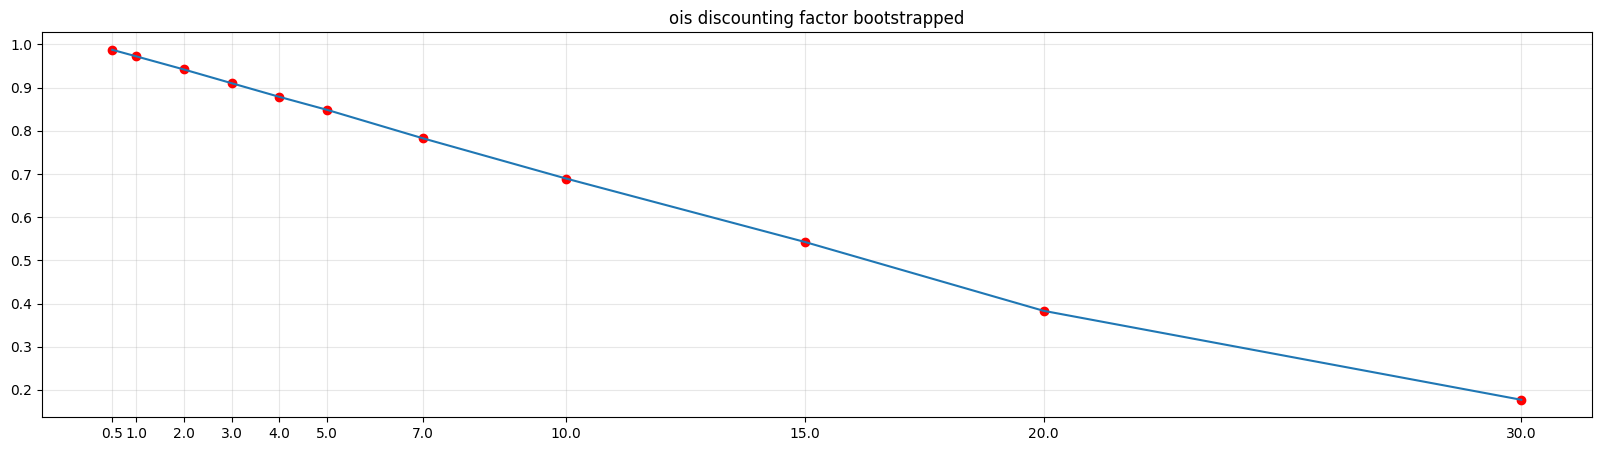

In [55]:
plt.figure(figsize=(20, 5))
plt.title("ois discounting factor bootstrapped")
plt.plot(irs_data["tenor"], irs_data["disc_factor"], "ro")
plt.plot(irs_data["tenor"], irs_data["disc_factor"])


plt.xticks(irs_data["tenor"])
plt.grid(alpha=0.3)

In [56]:
df_result = pd.DataFrame([np.arange(0.5, 30.5, 0.5), previous_disc_factors]).T
df_result.columns = ['tenor','disc_factor']

In [57]:
for x in df_result.index:
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [58]:
for x in df_result.index:
    if x>0:
        df_result.loc[x,'par_rate'] = (1-df_result.loc[x,'disc_factor'])/ (0.5 * df_result.loc[0:x,'disc_factor'].sum())
    if x == 0:
        df_result.loc[x,'par_rate'] = 0.025

/tmp/ipykernel_3851/1882064984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0292498482783729' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_result.loc[x,'par_rate'] = (1-df_result.loc[x,'disc_factor'])/ (0.5 * df_result.loc[0:x,'disc_factor'].sum())


In [59]:
irs_data

,tenor,product,rate,tenor_diff,interp_count,disc_factor
0,0.5,LIBOR,0.0250,0.0,0,0.987654
1,1.0,IRS,0.0280,0.5,1,0.972557
2,2.0,IRS,0.0300,1.0,2,0.942105282898963
3,3.0,IRS,0.0315,1.0,2,0.910285962086782
4,4.0,IRS,0.0325,1.0,2,0.878625331494003
5,5.0,IRS,0.0330,1.0,2,0.848508777669459
6,7.0,IRS,0.0350,2.0,4,0.782806357895841
7,10.0,IRS,0.0370,3.0,6,0.689542614303887
8,15.0,IRS,0.0400,5.0,10,0.542623025724946
9,20.0,IRS,0.0450,5.0,10,0.383101510643749


In [60]:
df_result

,tenor,disc_factor,par_rate
0,0.5,0.987654,0.025
1,1.0,0.972557,0.028
2,1.5,0.957331161916036,0.0292498482783729
3,2.0,0.942105282898963,0.0300000000000001
4,2.5,0.926195622492873,0.0308427881515643
5,3.0,0.910285962086782,0.0315000000000001
6,3.5,0.894455646790392,0.0320288267579784
7,4.0,0.878625331494003,0.0325000000000001
8,4.5,0.863567054581731,0.0327460913626095
9,5.0,0.848508777669459,0.0329999999999999
